<a href="https://colab.research.google.com/github/peterliujpdev/MNIST-Digit-Recognizer/blob/main/MNIST_Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Math Intuition



1. Pytorch structure

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 1. 卷积层 Convolutional Layers
        # 输入通道 1 (黑白图), 输出通道 32 (提取32种特征), 卷积核 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        # 输入通道 32, 输出通道 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        # 2. 全连接层 Fully Connected Layers
        # 计算维度
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10) # 输出数字

    def forward(self, x):
        # 第一层卷积 + 激活函数 ReLU + 池化 Pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 图片变小一半

        # 第二层卷积
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # 展平 Flatten: 把立体的数据拍扁成一维向量，准备喂给全连接层
        x = torch.flatten(x, 1)

        # 全连接分类
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # 输出 Logits (未归一化的概率)
        return x

# 实例化模型
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ==========================================
# Data Preparation
# ==========================================
# 把图片变成 Tensor 矩阵，并让数值在 0-1 之间
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 下载训练集 (60,000)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# 下载测试集 (10,000)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 建立加载器 (Batch Size = 64 每次并行计算 64 张图，利用矩阵加速)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# ==========================================
# Model Architecture
# ==========================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 卷积层提取特征
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # 池化层降维 选最大值
        self.pool = nn.MaxPool2d(2, 2)
        # 全连接层分类
        # 28x28 的图经过两次池化变成 7x7。
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 输出 10 个数字的概率

    def forward(self, x):
        # Layer 1
        x = self.pool(torch.relu(self.conv1(x)))
        # Layer 2
        x = self.pool(torch.relu(self.conv2(x)))
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        # Fully Connect
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# ==========================================
# Math Setup
# ==========================================
# Loss Function: CrossEntropy
criterion = nn.CrossEntropyLoss()
# Optimizer: SGD 的进化版 Adam
# 0.001 Learning Rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# The Training Loop
# ==========================================
print("🚀 Training Starts... ")

num_epochs = 3 # 把所有数据看 3 遍

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # 1. Reset Gradients
        optimizer.zero_grad()

        # 2. Forward Pass
        outputs = model(images)

        # 3. Calculate Loss
        loss = criterion(outputs, labels)

        # 4. Backward Pass - Chain Rule
        # 每个参数对误差的贡献
        loss.backward()

        # 5.Update Weights
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("✅ Training Complete！")

# ==========================================
# Evaluation
# ==========================================
model.eval() # 测试模式
correct = 0
total = 0
with torch.no_grad(): # 测试不需要算梯度
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 选概率最大的那个数字
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'🎉 在 10,000 张测试图片上的准确率: {100 * correct / total:.2f}%')

🚀 Training Starts... 
Epoch [1/3], Step [100/938], Loss: 0.2996
Epoch [1/3], Step [200/938], Loss: 0.1193
Epoch [1/3], Step [300/938], Loss: 0.0573
Epoch [1/3], Step [400/938], Loss: 0.0758
Epoch [1/3], Step [500/938], Loss: 0.0304
Epoch [1/3], Step [600/938], Loss: 0.0617
Epoch [1/3], Step [700/938], Loss: 0.1924
Epoch [1/3], Step [800/938], Loss: 0.0972
Epoch [1/3], Step [900/938], Loss: 0.0300
Epoch [2/3], Step [100/938], Loss: 0.0419
Epoch [2/3], Step [200/938], Loss: 0.0652
Epoch [2/3], Step [300/938], Loss: 0.1928
Epoch [2/3], Step [400/938], Loss: 0.0124
Epoch [2/3], Step [500/938], Loss: 0.1445
Epoch [2/3], Step [600/938], Loss: 0.1554
Epoch [2/3], Step [700/938], Loss: 0.0083
Epoch [2/3], Step [800/938], Loss: 0.0067
Epoch [2/3], Step [900/938], Loss: 0.0350
Epoch [3/3], Step [100/938], Loss: 0.0385
Epoch [3/3], Step [200/938], Loss: 0.0061
Epoch [3/3], Step [300/938], Loss: 0.0345
Epoch [3/3], Step [400/938], Loss: 0.0086
Epoch [3/3], Step [500/938], Loss: 0.0023
Epoch [3/3],

Press the button to upload any number pictures (black number with white background)...


Saving image6.jpg to image6 (2).jpg


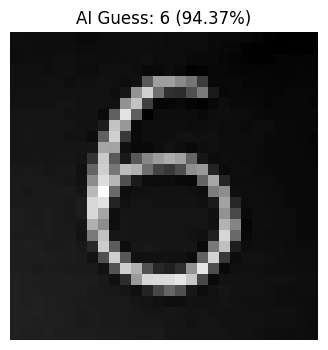

In [7]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from google.colab import files
import torch.nn.functional as F

def predict_my_image():
    # 1. 弹出上传按钮
    print("Press the button to upload any number pictures (black number with white background)...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # 2. 打开图片
        image = Image.open(filename)

        # 3. 图片预处理
        # 3.1 转为灰度图 (RGB -> Gray)
        img_gray = image.convert('L')

        # 3.2 颜色反转 (MNIST 为黑底白字)
        img_inverted = ImageOps.invert(img_gray)

        # 3.3 调整大小为 28x28
        img_resized = img_inverted.resize((28, 28))

        # 3.4 转为 Tensor 并增加维度 ([1, 1, 28, 28])
        img_tensor = transform(img_resized).unsqueeze(0).to(device)

        # 4. 让模型预测
        model.eval() # 切换到评估模式
        with torch.no_grad():
            output = model(img_tensor)
            # Softmax 计算概率
            probabilities = F.softmax(output, dim=1)
            prediction = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][prediction].item() * 100

        # 5. print
        plt.figure(figsize=(4, 4))
        plt.imshow(img_resized, cmap='gray')
        plt.title(f"AI Guess: {prediction} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()

# Finally predict
predict_my_image()